In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import hyp1f1
import scienceplots

In [2]:
# Define grid for plotting
x = np.linspace(-4, 4, 1000)

# === Ensemble
q1_means = [-1, 1]
q1_stds = [5,0.5,0.005] # fixed standard deviation

n_means = len(q1_means)
n_stds = len(q1_stds)

In [3]:
# Variance based measure
eu_var = np.zeros((len(q1_stds),1)) + 2*np.var(q1_means)

# Entropy based measure
def entropy_eu(mu, sigma, nu, tau):
    return np.log(tau/sigma) + (sigma**2 + (mu - nu)**2) / (2 * tau**2) - 1/2


eu_entropy = np.zeros((len(q1_stds),1))
for i in range(n_means):
    for j in range(n_means):
        if i != j:
            for k in range(len(q1_stds)):
                eu_entropy[k] += entropy_eu(q1_means[i], q1_stds[k], q1_means[j], q1_stds[k]) / n_means**2


# CRPS based measure
def crps_eu(mu, sigma, nu, tau):
    return np.sqrt(sigma**2 + tau**2) * np.sqrt(2/np.pi) * hyp1f1(-1/2, 1/2, -1/2 * (mu-nu)**2 / (sigma**2 + tau**2)) - (sigma + tau) / np.sqrt(np.pi)

eu_crps = np.zeros((len(q1_stds),1))
for i in range(n_means):
    for j in range(n_means):
        if i != j:
            for k in range(len(q1_stds)):
                eu_crps[k] += crps_eu(q1_means[i], q1_stds[k], q1_means[j], q1_stds[k]) / n_means**2



# Kernel entropy based measure
def kernel_eu(mu, sigma, nu, tau, gamma = 1):
    fac1 = 1/2 * np.sqrt(gamma**2 / (gamma**2 + 4*sigma**2))
    fac2 = 1/2 * np.sqrt(gamma**2 / (gamma**2 + 4*tau**2))
    fac3 = np.sqrt(gamma**2 / (gamma**2 + 2*(sigma**2 + tau**2)))*np.exp(-(mu-nu)**2 / (gamma**2 + 2*(sigma**2 + tau**2)))
    return fac1 + fac2 - fac3

eu_kernel_entropy = np.zeros((len(q1_stds),1))
for i in range(n_means):
    for j in range(n_means):
        if i != j:
            for k in range(len(q1_stds)):
                eu_kernel_entropy[k] += kernel_eu(q1_means[i], q1_stds[k], q1_means[j], q1_stds[k]) / n_means**2

eu_var = eu_var.flatten()
eu_entropy = eu_entropy.flatten()
eu_crps = eu_crps.flatten()
eu_kernel_entropy = eu_kernel_entropy.flatten()

In [4]:
print(f"Variance based measure: {eu_var.flatten()}")
print(f"Entropy based measure: {eu_entropy.flatten()}")
print(f"CRPS based measure: {eu_crps.flatten()}")
print(f"Kernel entropy based measure: {eu_kernel_entropy.flatten()}")

Variance based measure: [2. 2. 2.]
Entropy based measure: [4.e-02 4.e+00 4.e+04]
CRPS based measure: [0.11209164 0.71839422 0.99717905]
Kernel entropy based measure: [0.00193186 0.30570514 0.49081398]


In [5]:
plt.style.use('science')

In [6]:
ticksize = 17
labelsize = 22
titlesize = 26
legendsize = 24
color = "darkblue"

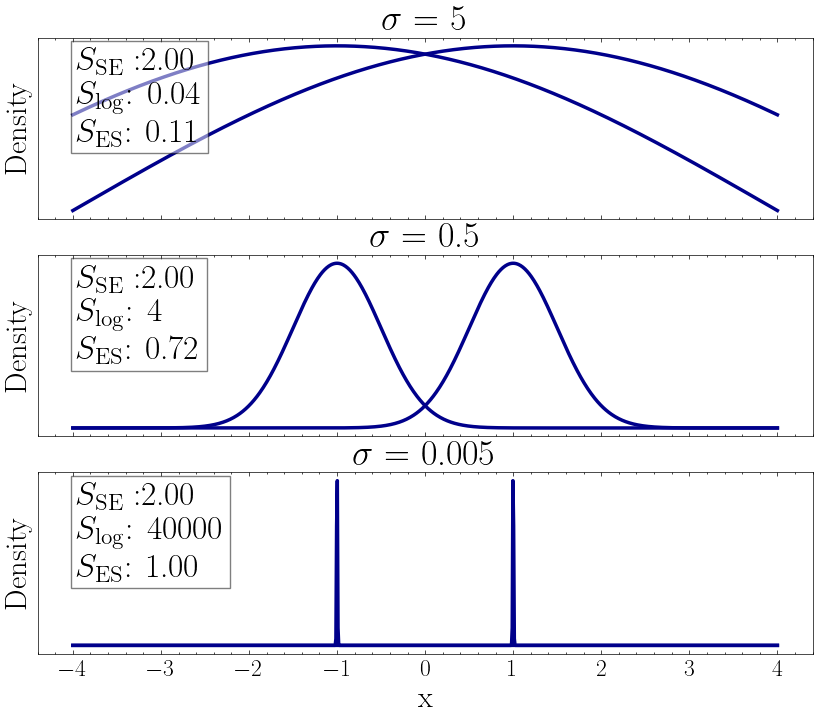

In [7]:
# === Plotting ===
fig, axs = plt.subplots(n_stds, 1, figsize=(10, 8), sharex=True)
axs = axs.ravel()


for i,std in enumerate(q1_stds):
    q1_components = [norm(loc=mu, scale=std) for mu in q1_means]
    q1_density = np.mean([comp.pdf(x) for comp in q1_components], axis=0)
    # Plot individual densities
    for comp in q1_components:
        axs[i].plot(x, comp.pdf(x), color = color, lw = 2.5)
    # Plot Q1
   # axs[i].plot(x, q1_density, label='Q1: Means = [-1, 0, 1]', color='blue')
    axs[i].set_title(rf'$\sigma$ = {std}', size = titlesize)
    axs[i].set_ylabel('Density', size = labelsize)
    axs[i].set_yticks([])

    # Insert label with values of measures inside a box
    if i == 0:
        text = r'$S_\mathrm{SE}: $' + f'{eu_var[i]:.2f}\n' + r'$S_\mathrm{log}$: ' + f'{eu_entropy[i]:.2f}\n' + r'$S_\mathrm{ES}$: ' + f'{eu_crps[i]:.2f}'
    else:
        text = r'$S_\mathrm{SE}: $' + f'{eu_var[i]:.2f}\n' + r'$S_\mathrm{log}$: ' + f'{eu_entropy[i]:.0f}\n' + r'$S_\mathrm{ES}$: ' + f'{eu_crps[i]:.2f}'

    axs[i].text(0.05, 0.95, text, transform=axs[i].transAxes, fontsize=legendsize,
                verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
    
axs[2].set_xlabel('x', size = labelsize)
axs[2].tick_params(axis='both', which='major', labelsize=ticksize)


plt.savefig("plots/eu_ensemble.pdf", dpi = 300, bbox_inches='tight')